# Adversarial Attacks Tutorial
Modified from https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm.

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

This tutorial creates an *adversarial example* using the Fast Gradient Signed Method (FGSM) attack as described in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) by Goodfellow *et al*. This was one of the first and most popular attacks to fool a neural network. 

## What is an adversarial example?

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a *white box* attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked.

## Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy find how each input pixel contributes to the loss, by using the chain rule, and finding the required gradients. Hence, the gradients are used with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.

So let's try and fool a pretrained model. In this tutorial, the model is [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) model, pretrained on [ImageNet](http://www.image-net.org/).

In [ ]:
# ! pip3 install cython
# ! pip3 install tensornets
# ! pip3 install numpy==1.16.1

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensornets as nets

%matplotlib notebook
plt.style.use("seaborn-bright")

Let's define the computation graph.

In [2]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = image /  127.5
  image = image - 1.0
  image = image[None, ...]
  return image
def reverse_preprocess(image):
  image = image + 1.0
  image = image / 2.0
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=5)[0]

image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_png(image_raw)
input_image = preprocess(image)
reversed_image = reverse_preprocess(input_image)

input_image_placeholder = tf.placeholder(shape=[1, 224, 224, 3], dtype=tf.float32)

pretrained_model = nets.MobileNet50v2(input_image_placeholder, reuse=tf.AUTO_REUSE)

# node to load pretrained weights
pretrained_ops = pretrained_model.pretrained()

# decode predicted probabilities to ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

W0722 14:43:23.863037 140302288160576 deprecation_wrapper.py:119] From /home/ubuntu/.local/lib/python3.6/site-packages/tensornets/utils.py:238: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0722 14:43:24.123835 140302288160576 deprecation_wrapper.py:119] From /home/ubuntu/.local/lib/python3.6/site-packages/tensornets/utils.py:277: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W0722 14:43:26.210517 140302288160576 deprecation_wrapper.py:119] From /home/ubuntu/.local/lib/python3.6/site-packages/tensornets/utils.py:246: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 14:43:26.211556 140302288160576 deprecation_wrapper.py:119] From /home/ubuntu/.local/lib/python3.6/site-packages/tensornets/utils.py:125: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0722 14:43:26.700242 140302288160576 deprecat

## Original image
Let's use a sample image of a [Labrador Retriever](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) -by Mirko       [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) from Wikimedia Common and create adversarial examples from it. The first step is to preprocess it so that it can be fed as an input to the MobileNetV2 model.

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)

sess.run(pretrained_ops)
preprocessed_img, reversed_img = sess.run([input_image, reversed_image])
image_probs = sess.run([pretrained_model], {input_image_placeholder:preprocessed_img})

Let's have a look at the image.

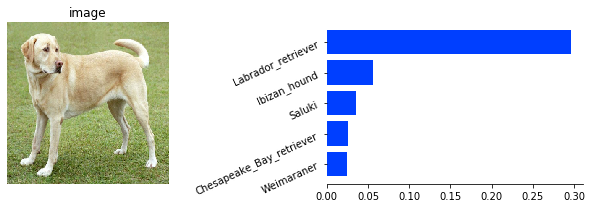

In [4]:
top5 = get_imagenet_label(image_probs[0])
tick_names = [x[1] for x in top5]
probs = [x[2] for x in top5]
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.imshow(reversed_img[0])
plt.title('image')
ax = plt.gca()
ax.axis('off')

plt.subplot(122)
tick_names = [x[1] for x in reversed(top5)]
probs = [x[2] for x in reversed(top5)]
plt.barh(tick_names, probs)
plt.yticks(rotation=25)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()

## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [5]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  loss = loss_object(input_label, pretrained_model)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = tf.gradients(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)[0]
  return signed_grad

The resulting perturbations can also be visualised.

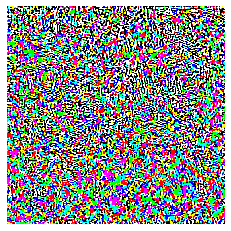

In [6]:
import numpy as np

perturbations = create_adversarial_pattern(input_image_placeholder, tf.argmax(pretrained_model,1))
p_cliped = tf.clip_by_value(perturbations, 0, 1)

p_cliped_val = sess.run(p_cliped, {input_image_placeholder: preprocessed_img})
plt.figure()
plt.imshow(p_cliped_val[0])
plt.gca().axis('off')
plt.show()

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network, however, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [7]:
def display_images(image, description):
  rev_image = reverse_preprocess(image)
  adv_img, raw_adv_img = sess.run([image, rev_image], {input_image_placeholder: preprocessed_img})
  img_probs = sess.run(pretrained_model, {input_image_placeholder: adv_img})
  top5 = get_imagenet_label(img_probs)
  top5 = list(reversed(top5))
  plt.figure(figsize=(9, 3))
  plt.subplot(121)
  plt.imshow(raw_adv_img[0])
  plt.title(description)
  plt.gca().axis('off')
  plt.subplot(122)
  tick_names = [x[1] for x in top5]
  probs = [x[2] for x in top5]
  plt.barh(tick_names, probs)
  plt.yticks(rotation=25)
  ax = plt.gca()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  plt.tight_layout()
  plt.show()

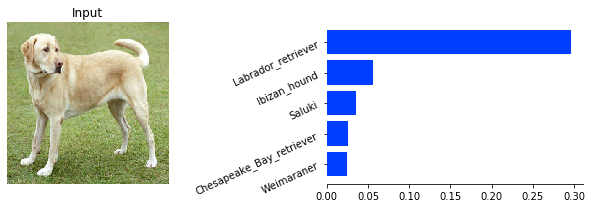

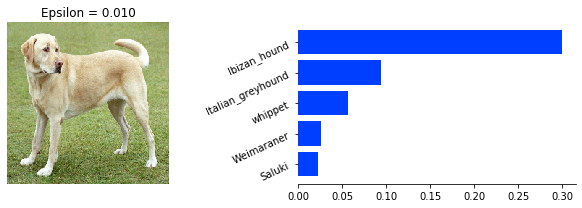

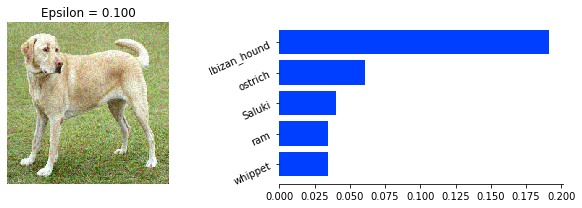

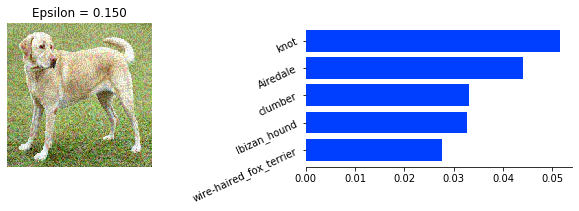

In [8]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = input_image_placeholder + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

sess.close()